# Import necessary packages

In [3]:
import os
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from eval import get_run_metrics, read_run_dir, get_model_from_run
from samplers import get_data_sampler, sample_transformation
from tasks import get_task_sampler
from models import LeastSquaresModel
from matplotlib.ticker import MaxNLocator

import numpy as np
from scipy.signal import savgol_filter

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'whitegrid')
palette = sns.color_palette('colorblind')

In [7]:
run_dir = "/Users/harmonbhasin/hsbhasin@wisc.edu - Google Drive/My Drive/ICL/Models"
df = read_run_dir(run_dir)

# Define function for multiple model plotting

In [11]:
def run_evaluation(subset_models, task_args, data_args, seed, att_mask=None):
    models = {}
    configs = {}
    n_points = 100
    n_dims = 20
    b_size = 64

    for key in subset_models:
        task = df.task[subset_models[key]]
        run_id = df.run_id[subset_models[key]]
        run_path = os.path.join(run_dir, task, run_id)
        models[key], configs[key] = get_model_from_run(run_path)

    preDict = {}
    yDict = {}

    for task_key in task_args:
        current_task = task_args[task_key]
        task_sampler = get_task_sampler(
            current_task['task'],
            n_dims,
            b_size,
            **{i: current_task[i] for i in current_task if i != 'task'}
        )
        print('Conducting evaluation on', current_task['task'], 'with degree of ', current_task['degree'], '\n')
        for data_key in data_args:
            torch.manual_seed(seed)
            current_data = data_args[data_key]
            sample_args = {}

            if current_data['type'] == 'Skewed':
                eigenvals = 1 / (torch.arange(n_dims) + 1)
                scale = sample_transformation(eigenvals, normalize=True)
                sample_args['scale'] = scale

            for data_info in current_data:
                if data_info != 'data' and data_info != 'type':
                    sample_args[data_info] = current_data[data_info]

            data_sampler = get_data_sampler(current_data['data'], n_dims, **sample_args)

            # Create an instance of the function class sampler; add seed stuff here
            task = task_sampler()

            # Generate x points; add seed stuff here
            xs = data_sampler.sample_xs(n_points, b_size)

            # Generate y points
            ys = task.evaluate(xs)

            yDict[f"{task_key}_{data_key}"] = ys

            for model_key in models:
                prompt_col = 0
                prompt_row = 0
                conf = configs[model_key]['training']
                prompt_args = conf['prompt_kwargs']
                if len(prompt_args) != 0:
                       if prompt_args['type'] == 'data':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(data_key[-1])
                           prompt_col = prompt_args['position']
                       elif prompt_args['type'] == 'task':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(task_key[-1])
                           prompt_col = prompt_args['position']

                temp_key = f"{model_key}_{task_key}_{data_key}"
                with torch.no_grad():
                    if att_mask is None:
                        _, _, preDict[temp_key] = models[model_key](xs,
                                                            ys,
                                                            conf['prompt_type'],
                                                            prompt_row,
                                                            prompt_col)
                    else:
                        _, _, preDict[temp_key] = models[model_key](xs,
                                                            ys,
                                                            conf['prompt_type'],
                                                            prompt_row,
                                                            prompt_col,
                                                            att_mask=att_mask)

                    if conf['prompt_type'] == 'standard':
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution')
                    else:
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution with instruction in row', prompt_row, 'and column', prompt_col)
            OLS = LeastSquaresModel()
            preDict[f'OLS_{task_key}_{data_key}'] = OLS(xs, ys)

    lossDict = {}
    for pred_key in preDict:
        for y_key in yDict:
            if y_key in pred_key:
                lossDict[pred_key] = (yDict[y_key] - preDict[pred_key]).square().numpy()

    different_plots = {}

    for key in lossDict:
        components = key.split('_')
        model = components[0]
        task = components[1]
        data = components[2]
        task_data = f"{task}_{data}"
        if task_data not in different_plots:
            different_plots[task_data] = {}
        different_plots[task_data][model] = lossDict[key]

    return different_plots, configs

In [11]:
from matplotlib.ticker import FuncFormatter
def format_y_axis(value, _):
    return f'{value:.2e}'  # Format in scientific notation with two decimal places


def plot_results_horizontal_individual(different_plots, configs,task_args, data_args, type, head_dir, smooth, window_size = 10, limit_y=False, y_lim_low=[-0.1,-0.1, -0.1], y_lim_high=[1.0,1.0,1.0], width=12,height=4, legend=False, include_title=False, grid=False, scinot=False, force_ticks=False, format_two=False, name=None):
    sns.set_palette("Set3")
    color_index = 0
    for key in configs:
        if key != 'OLS':
            if 'Mixed' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Mixed model'
            elif 'Random' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Random model'
            elif 'Sequential' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Sequential model'
            elif 'Skewed Gaussian' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Skewed gaussian model'
            elif 'Gaussian' in configs[key]['wandb']['name'] and type == 'task':
                configs[key]['name'] = 'Linear model'
            elif 'Gaussian' in configs[key]['wandb']['name'] and type == 'sample':
                configs[key]['name'] = 'Gaussian model'
            elif 'Binomial' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Quadratic model'
            elif 'Trinomial' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Cubic model'
            elif 'Student-T' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Student t model'
          


            if configs[key]['training']['prompt_type'] != 'standard':
                configs[key]['ls'] = 'dashed'
            else:
                configs[key]['ls'] = 'solid'
            configs[key]['c'] = sns.color_palette()[color_index]
            color_index +=1

    configs['OLS'] = {}
    configs['OLS']['name'] = 'Least Squares'
    configs['OLS']['ls'] = 'dashdot'
    configs['OLS']['c'] = 'black'

    num_cols = len(different_plots)

    plt.style.use('seaborn-whitegrid')
    model_dict = {}
    for index, task_data in enumerate(different_plots):
        for model in different_plots[task_data]:
            if model not in model_dict:
                _, model_dict[model] = plt.subplots(nrows=1, ncols=num_cols, figsize=(width,height), tight_layout=True)
            
            if smooth:
                    # Moving average via ChatGPT
                    smoothed_data = np.convolve(different_plots[task_data][model].mean(axis=0)/20, np.ones((window_size,))/window_size, mode='valid')
                    model_dict[model][index].plot(smoothed_data,
                                    lw=2,
                                    label=f"{configs[model]['name']} (MA)",
                                    color='#d95f02')
                    model_dict[model][index].plot(different_plots[task_data][model].mean(axis=0)/20,
                                    lw=2,
                                    label=configs[model]['name'],
                                    color='#7570b3',
                                    ls='dotted')
                    #model_dict[model][index].set_title(f"{configs[model]['name']}")
    for key in model_dict:
        if grid == False:
            model_dict[key][2].legend(prop={'family': 'Times New Roman', 'size': 10}, loc='upper right', frameon=True)
        model_dict[key][0].set_ylabel("Normalized MSE", fontname='Times New Roman', fontsize=12)
        for ax in model_dict[key]:
            ax.set_ylim(0)
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            #ax.figure.patch.set_facecolor('white')
            #ax.legend(prop={'family': 'Times New Roman', 'size': 12})
            #ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune='both'))
            #ax.tick_params(axis='x', rotation=90)
            if force_ticks:
                ax.yaxis.set_major_locator(MaxNLocator(5))
            if format_two:
                ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))
            if scinot:
                ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                ax.xaxis.offsetText.set_fontname('Times New Roman')
                ax.yaxis.offsetText.set_fontname('Times New Roman')
            for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontname('Times New Roman')
                label.set_fontsize(12)
            if grid == True:
                ax.legend(prop={'family': 'Times New Roman', 'size': 10}, loc='upper right', frameon=True)
           
            ax.set_xlabel("# in-context examples", fontname='Times New Roman', fontsize=12)
        if name == None:
            plt.savefig(f"{head_dir}/eval_{configs[key]['wandb']['name']}.pdf")
        else:
            plt.savefig(f"{head_dir}/{name}.pdf")

In [ ]:
index = 0
model_selection = {}
model_to_name = {}
for task_name in df.task:
    if ("model_12" in task_name or "model_11_gaussian" in task_name) and "_i" not in task_name and 'quad' not in task_name:
        task_index = df.loc[df["task"] == task_name].index[0]
        model_selection[f'model{index}'] = task_index
        print(f"model{index}:", task_name)
        model_to_name[f"model{index}"] = task_name
        index+=1

model0: model_11_gaussian
model1: model_12_binomial
model2: model_12_trinomial
model3: model_12_mixed_multi_task_model
model4: model_12_random_multi_task_model
model5: model_12_sequential_multi_task_model


In [ ]:
# Model to evaluate against
task_args = {'task0': {'task': "hermite_regression", 'degree': 1},
             'task1': {'task': "hermite_regression", 'degree': 2},
             'task2': {'task': "hermite_regression", 'degree': 3}}

data_args = {'data0': {'data': 'gaussian', 'type': 'Standard'}}
seed=-152

## Evaluate chosen models

In [ ]:
different_plots, configs = run_evaluation(subset_models=model_selection,
                   task_args=task_args,
                   data_args=data_args,
                   seed=seed)

Conducting evaluation on hermite_regression with degree of  1 

Gaussian (Model Three) evaluated on Standard gaussian distribution
Hermite Binomial evaluated on Standard gaussian distribution
Hermite Trinomial evaluated on Standard gaussian distribution
Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Random Hermite Polynomial evaluated on Standard gaussian distribution
Sequential Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  2 

Gaussian (Model Three) evaluated on Standard gaussian distribution
Hermite Binomial evaluated on Standard gaussian distribution
Hermite Trinomial evaluated on Standard gaussian distribution
Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Random Hermite Polynomial evaluated on Standard gaussian distribution
Sequential Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  3 

Ga

## Selecting specific models to plot


In [ ]:
# Display all available models
#for key in different_plots['task0_data0']:
for key in different_plots['task1_data0']:
    if key == 'OLS':
        print('OLS')
    else:
        print(f"{key} = {model_to_name[key]}")


model0 = model_11_gaussian
model1 = model_12_binomial
model2 = model_12_trinomial
model3 = model_12_mixed_multi_task_model
model4 = model_12_random_multi_task_model
model5 = model_12_sequential_multi_task_model
OLS


In [ ]:
select_models = True # Set this true if you only want to plot some of the models that you evaluated on
models_you_want = ['model0', 'model1', 'model2', 'model3', 'model4', 'model5']
#models_you_want = ['model0']

In [ ]:
# Select models specified in previous cell
eval_calculations={}
changeable_config={}

if select_models:
    for key in copy.deepcopy(different_plots):
        current_task_data = different_plots[key]
        eval_calculations[key] = {second_key: current_task_data[second_key] for second_key in models_you_want}
            
    for config_key in models_you_want:
        if config_key != 'OLS':
            changeable_config[config_key] = copy.deepcopy(configs)[config_key]
else:
    eval_calculations = copy.deepcopy(different_plots)
    changeable_config = copy.deepcopy(configs)

In [ ]:
head_dir="/Users/harmonbhasin/College/Research/huLab/paper_figures/new_task"

## Code to evaluate and plot models


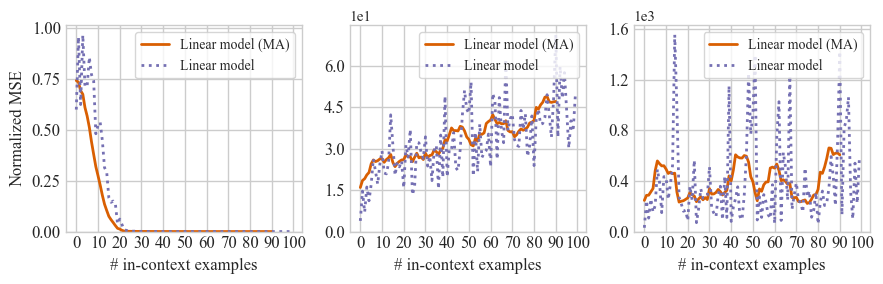

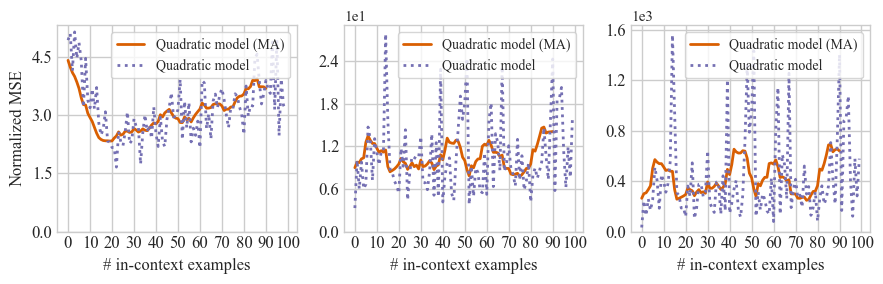

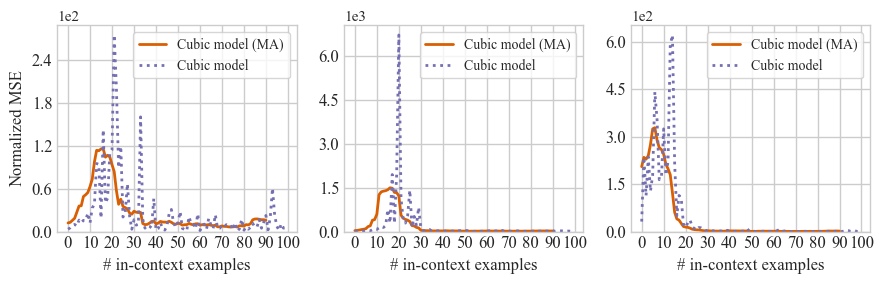

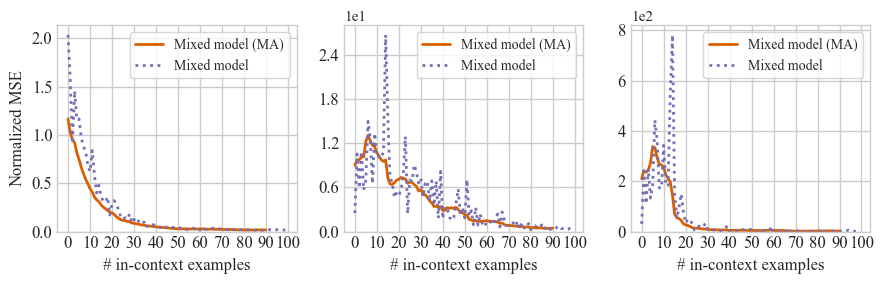

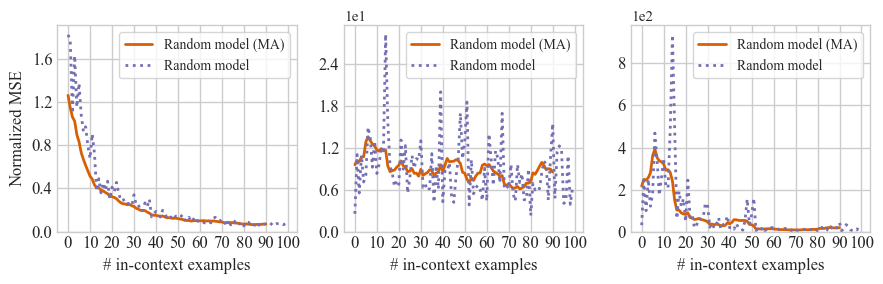

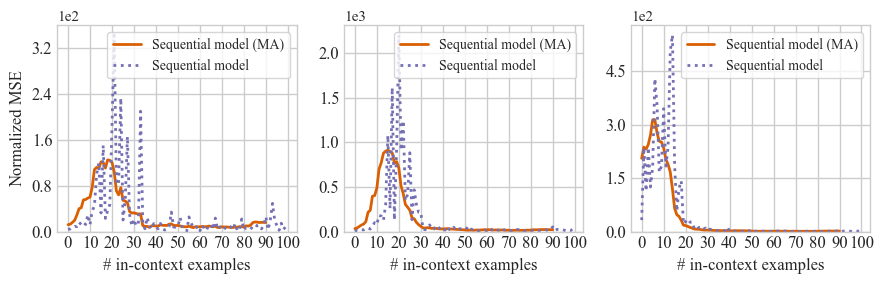

In [ ]:
#y_lim_low=[0, 0, 0, 0]
#y_lim_high=[1, 5, 10, 0.4]

for target_key in models_you_want:
    subdict={}
    for outer_key, inner_dict in eval_calculations.items():
        if target_key in inner_dict:
            subdict[outer_key] = {target_key : inner_dict[target_key]}
    plot_results_horizontal_individual(different_plots=subdict,
                configs=changeable_config,
                task_args=task_args,
                data_args=data_args,
                type='task',
                limit_y=False,
                head_dir=head_dir,
                smooth=True,
                width=9,
                height=3,
                grid=True,
                scinot=True,
                force_ticks=True,
                )